In [25]:
np.random.seed(1729)

In [4]:
original_df = pd.read_csv(r'../../datasets/continuous_w_discreteTarget/WineQT.csv')
original_df = original_df.loc[:, ~original_df.columns.isin(['Id'])]
original_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
columns = list(original_df.columns)
n_samples, n_features = original_df.shape

In [5]:
synthetic_df = pd.read_csv(r'../../datasets/continuous_w_discreteTarget/synthetic.csv')
synthetic_df = synthetic_df[columns]
synthetic_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,5.968890,0.546081,0.187606,2.103910,0.084351,10.599370,25.803488,0.996072,3.657127,0.702851,10.415288,5
1,11.105190,0.540816,0.385208,2.275519,0.085218,19.624531,40.004424,1.002522,3.284319,1.013026,8.754856,5
2,6.832196,0.476276,0.213140,2.343784,0.072973,6.462645,45.746740,0.997408,3.440267,0.593557,11.306660,5
3,6.828801,0.433068,0.058927,2.229671,0.058133,16.240428,30.657016,0.996891,3.484843,0.817363,11.100136,5
4,9.051974,0.633480,0.208348,2.255440,0.082308,12.835838,45.295182,0.997639,3.281660,0.516698,10.069816,5


In [6]:
from sklearn.preprocessing import LabelEncoder


predictors = {'categorical': ['quality'],
              'continuous': ['fixed acidity', 'volatile acidity', 'citric acid',
              'residual sugar', 'chlorides', 'free sulfur dioxide',
              'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']}


def to_numpy(df, columns):
    """
    Convert dataframe to numpy array by converting categorical variables as integer labels
    :param df: The dataframe to convert
    :param columns: The continuous & discrete columns
    :return: Converted numpy arrays of X & Y and the label encoders
    """
    # Fetch the columns from the dataframe
    _columns = list(df.columns)

    # declaring empty arrays for the predictor and target variables
    X = np.empty(df[_columns].shape)

    # Assign the values from the columns, that are declared continuous,
    # into the corresponding positions in the numpy array
    for i, col in enumerate(columns['continuous']):
        X[:, _columns.index(col)] = df[col]

    # Encoding for X (predictors)
    for i, col in enumerate(columns['categorical']):
        # Initialize, fit and store the label encoder for column
        enc = LabelEncoder()
        enc.fit(df[col])

        # Transform the column using the encoder object
        X[:, _columns.index(col)] = enc.transform(df[col])

    return X


original_X = to_numpy(original_df, predictors)
synthetic_X = to_numpy(synthetic_df, predictors)

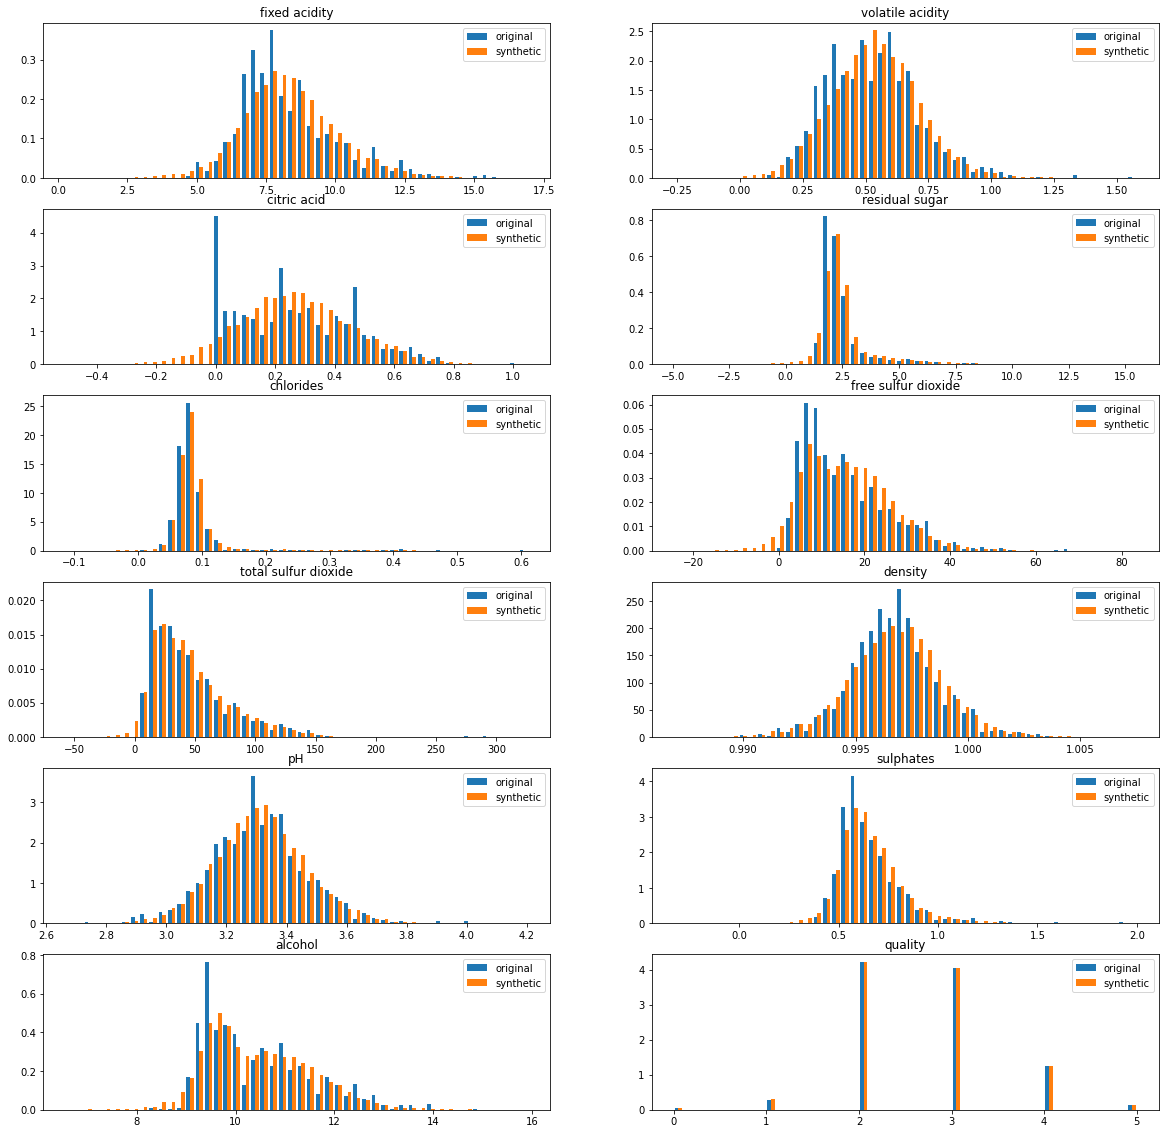

In [7]:
# plotting the distribution of the features using histogram

fig_rows = int(n_features/2) if n_features % 2 == 0 else int(n_features/2 + 1)
fig_columns = 2
bins = 50

fig,ax = plt.subplots(fig_rows, fig_columns, figsize=(20,20))
for i, feature in enumerate(range(n_features)):
    row_num = int(feature/fig_columns)
    col_num = feature%fig_columns
    if len(ax.shape) > 1:
        ax[row_num, col_num].hist([original_X[:, feature], synthetic_X[:, feature]],
                                  bins=bins, density=True,
                                  label=['original', 'synthetic'])
        ax[row_num, col_num].legend(['original', 'synthetic'])
        ax[row_num, col_num].title.set_text(f"{list(original_df.columns)[i]}")

    else:
        ax[col_num].hist([X[:, feature], Xn[0][:, feature]],
                         bins=bins, density=True,
                         label=['original', 'synthetic'])
        ax[col_num].legend(['original', 'synthetic'])
        ax[col_num].title.set_text(f"{list(original_df.columns)[i]}")


In [193]:
from scipy.stats import chisquare, ks_2samp, kstwo

print(list(original_df.columns))
categorical = ['quality']
continuous = ['fixed acidity', 'volatile acidity', 'citric acid',
              'residual sugar', 'chlorides', 'free sulfur dioxide',
              'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']



def get_probabilities(df, col):
    probs = []
    n = len(df[col])
    vals = sorted(list(df[col].unique()))
    cat_counts = df[col].value_counts()
    for cat in vals:
        probs.append(cat_counts[cat]/n)
    return vals, probs


for i, feature in enumerate(range(n_features)):
    column = columns[i]
    if column in categorical:
        unobserved = [i for i in list(original_df[column].unique()) if i not in list(synthetic_df[column].unique())]
        o_vals, o_probs = get_probabilities(original_df, column)
        s_vals, s_probs = get_probabilities(synthetic_df, column)
        for j in unobserved:
            s_probs.insert(o_vals.index(j), 0)
        pvalue = chisquare(f_obs=s_probs, f_exp=o_probs).pvalue
        print(f"p-value for col {column}: {pvalue}")
    else:
        n1 = original_X[:, i].shape[0]
        n2 = synthetic_X[:, i].shape[0]
        m, n = sorted([float(n1), float(n2)], reverse=True)
        en = m * n / (m + n)
        dist = abs(o_cum_hist[ind_max] - s_cum_hist[ind_max])
        
        data1 = original_X[:, i]
        data2 = synthetic_X[:, i]
        data_all = np.concatenate([data1, data2])
        cdf1 = np.searchsorted(data1, data_all, side='right') / n1
        cdf2 = np.searchsorted(data2, data_all, side='right') / n2
        cddiffs = cdf1 - cdf2
        # Ensure sign of minS is not negative.
        minS = np.clip(-np.min(cddiffs), 0, 1)
        maxS = np.max(cddiffs)
        pvalue = max(minS, maxS)
        
        print(f"p-value for col {column}: {pvalue}")
    

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
p-value for col fixed acidity: 0.9236563429571304
p-value for col volatile acidity: 0.9078
p-value for col citric acid: 0.9001034995625548
p-value for col residual sugar: 0.9505801399825022
p-value for col chlorides: 0.9944
p-value for col free sulfur dioxide: 0.9582550306211725
p-value for col total sulfur dioxide: 0.9820264216972878
p-value for col density: 0.9999
p-value for col pH: 0.9814268591426072
p-value for col sulphates: 0.9596762029746282
p-value for col alcohol: 0.8643524059492564
p-value for col quality: 0.9999999998946855


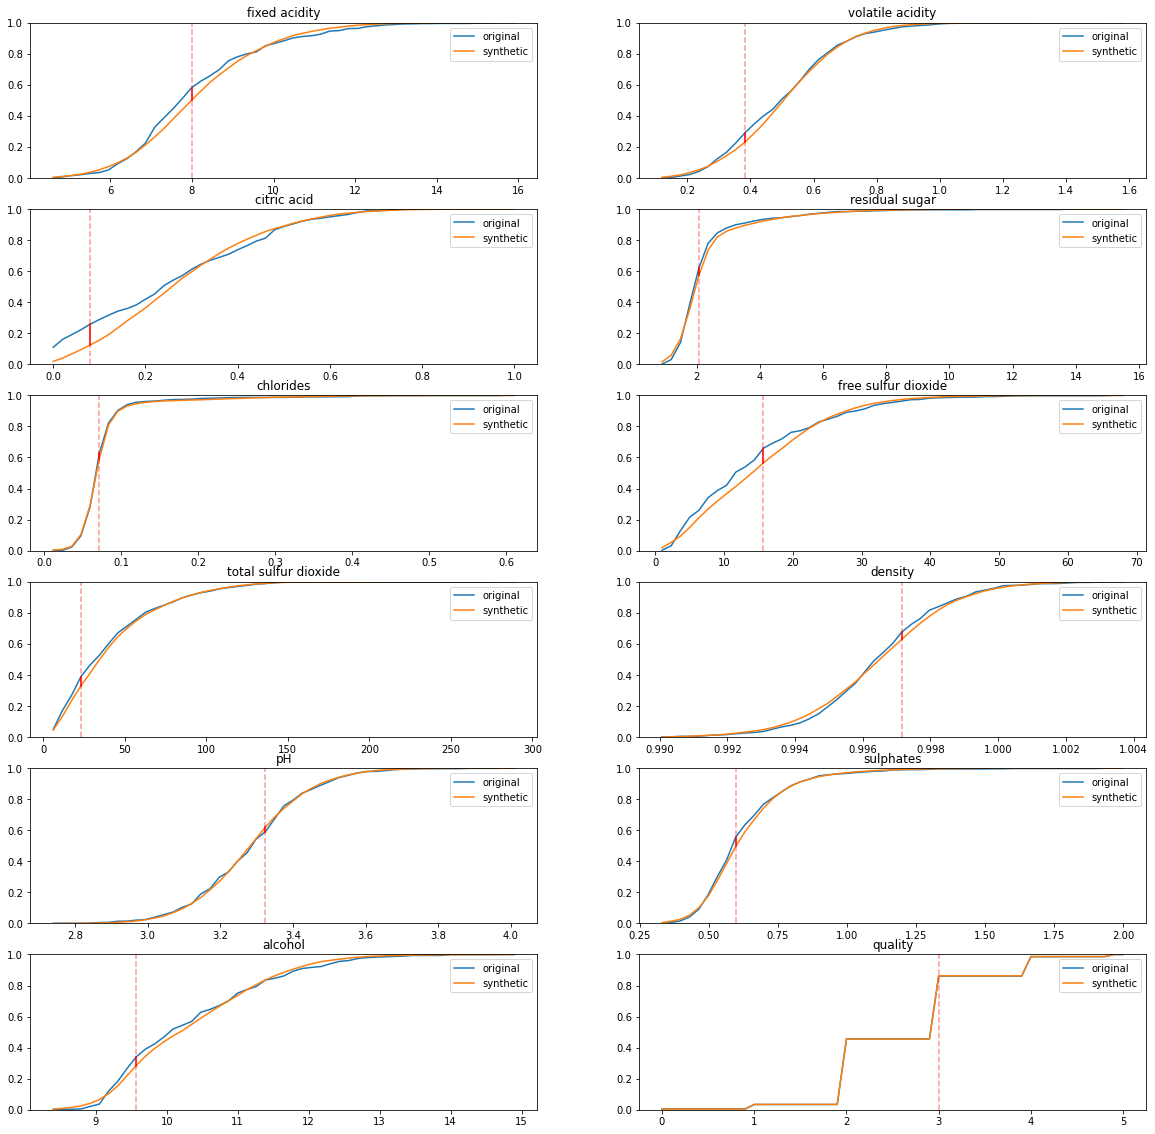

In [194]:
fig_rows = int(n_features/2) if n_features % 2 == 0 else int(n_features/2 + 1)
fig_columns = 2

fig,ax = plt.subplots(fig_rows, fig_columns, figsize=(20,20))
bins = 50

for i, feature in enumerate(range(n_features)):
    row_num = int(feature/fig_columns)
    col_num = feature%fig_columns
    
    o_rand = original_X[:, i]
    s_rand = synthetic_X[:, i]
#     o_rand = np.random.choice(original_X[:, i], 500)
#     s_rand = np.random.choice(synthetic_X[:, i], 500)
    
    o_hist, o_bin_edges = np.histogram(o_rand, bins=bins, density=True)
    o_scaled_hist = o_hist/sum(o_hist)
    o_cum_hist = list(np.cumsum(o_scaled_hist))
    o_cum_hist.append(1.0)
    
    s_hist, s_bin_edges = np.histogram(s_rand, bins=o_bin_edges, density=True)
    s_scaled_hist = s_hist/sum(s_hist)
    s_cum_hist = list(np.cumsum(s_scaled_hist))
    s_cum_hist.append(1.0)
    
    y = np.arange(1.0, len(o_bin_edges) + 1)/len(o_bin_edges)
    yc = np.interp(o_cum_hist, s_cum_hist, o_bin_edges)
    ind_max = np.argmax(np.subtract(o_cum_hist, s_cum_hist) ** 2)
    
    if len(ax.shape) > 1:
        ax[row_num, col_num].plot(o_bin_edges, o_cum_hist)
        ax[row_num, col_num].plot(s_bin_edges, s_cum_hist)
        ax[row_num, col_num].axvline(o_bin_edges[ind_max], color="red", linestyle="dashed", alpha=0.4)
        ax[row_num, col_num].plot([o_bin_edges[ind_max], o_bin_edges[ind_max]], [o_cum_hist[ind_max], s_cum_hist[ind_max]], color="red")
        ax[row_num, col_num].legend(['original', 'synthetic'])
        ax[row_num, col_num].title.set_text(f"{list(original_df.columns)[i]}")
        ax[row_num, col_num].set_ylim([0.0, 1.0])

    else:
        ax[row_num, col_num].plot(o_bin_edges, o_cum_hist)
        ax[row_num, col_num].plot(s_bin_edges, s_cum_hist)
        ax[row_num, col_num].axvline(o_bin_edges[ind_max], color="red", linestyle="dashed", alpha=0.4)
        ax[row_num, col_num].plot([o_bin_edges[ind_max], o_bin_edges[ind_max]], [o_cum_hist[ind_max], s_cum_hist[ind_max]], color="red")
        ax[col_num].legend(['original', 'synthetic'])
        ax[col_num].title.set_text(f"{list(original_df.columns)[i]}")
        ax[row_num, col_num].set_ylim([0.0, 1.0])



[ 4.6    4.826  5.052  5.278  5.504  5.73   5.956  6.182  6.408  6.634
  6.86   7.086  7.312  7.538  7.764  7.99   8.216  8.442  8.668  8.894
  9.12   9.346  9.572  9.798 10.024 10.25  10.476 10.702 10.928 11.154
 11.38  11.606 11.832 12.058 12.284 12.51  12.736 12.962 13.188 13.414
 13.64  13.866 14.092 14.318 14.544 14.77  14.996 15.222 15.448 15.674
 15.9  ]
[ 4.6    4.826  5.052  5.278  5.504  5.73   5.956  6.182  6.408  6.634
  6.86   7.086  7.312  7.538  7.764  7.99   8.216  8.442  8.668  8.894
  9.12   9.346  9.572  9.798 10.024 10.25  10.476 10.702 10.928 11.154
 11.38  11.606 11.832 12.058 12.284 12.51  12.736 12.962 13.188 13.414
 13.64  13.866 14.092 14.318 14.544 14.77  14.996 15.222 15.448 15.674
 15.9  ]
15
0.5809273840769906
0.5002530620508147


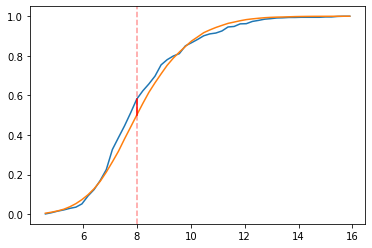

In [171]:
import scipy.stats as stats

np.random.seed(1729)

# data=np.random.uniform(low=1,high=10,size=50)
# x1= np.sort(data-np.mean(data))/np.std(data)
# y = np.arange(1.0, 51)/50

# x2 = stats.norm.ppf(y)
# print(x1)
# print(x2)
# print(y)
# yc = np.interp(x1, x2, y)
# print(yc)

# ind_max = np.argmax((yc-y)**2)

bins = 50
o_hist, o_bin_edges = np.histogram(original_X[:, 0], bins=bins, density=True)
o_scaled_hist = o_hist/sum(o_hist)
o_cum_hist = list(np.cumsum(o_scaled_hist))
o_cum_hist.append(1.0)

s_hist, s_bin_edges = np.histogram(synthetic_X[:, 0], bins=o_bin_edges, density=True)
s_scaled_hist = s_hist/sum(s_hist)
s_cum_hist = list(np.cumsum(s_scaled_hist))
s_cum_hist.append(1.0)

print(o_bin_edges)
print(s_bin_edges)

y = np.arange(1.0, len(o_bin_edges) + 1)/len(o_bin_edges)
yc = np.interp(o_cum_hist, s_cum_hist, o_bin_edges)
ind_max = np.argmax(np.subtract(o_cum_hist, s_cum_hist) ** 2)

print(ind_max)
print(o_cum_hist[ind_max])
print(s_cum_hist[ind_max])

plt.plot(o_bin_edges, o_cum_hist) #curve1
plt.plot(s_bin_edges, s_cum_hist) #curve2

plt.axvline(o_bin_edges[ind_max], color="red", linestyle="dashed", alpha=0.4)
plt.plot([o_bin_edges[ind_max], o_bin_edges[ind_max]], [o_cum_hist[ind_max], s_cum_hist[ind_max]], color="red")
plt.show()